### Импорт библиотек и загрузка данных

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.api import SimpleExpSmoothing


from scipy.optimize import minimize
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.graphics.tsaplots import plot_predict

from scipy.stats import boxcox

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
series = pd.read_csv("https://raw.githubusercontent.com/MelnikDM/Netology/main/Time_Series/data/weekly-closings-of-the-dowjones-.csv")["Close"]

### Определение основных функций

**Тест Дики-Фуллера на стационарность**

In [ ]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

**Функция вывода коррелограмм**

In [ ]:
def tsplot(y, lags=None, figsize=(12, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)

        plt.tight_layout()
    return

### ARCH и GARCH

Авторегрессионная условная гетероскедастичность (ARCH) — применяемая в эконометрике модель для анализа временных рядов, у которых условная (по прошлым значениям ряда) дисперсия ряда зависит от прошлых значений дисперсий. Данные модели предназначены для «объяснения» кластеризации волатильности на финансовых рынках, когда периоды высокой волатильности длятся некоторое время, сменяясь затем периодами низкой волатильности, причём среднюю волатильность можно считать относительно стабильной.

GARCH - это эквивалент ARMA для ARCH. ARCH имеет в своей основе только авторегрессионную компоненту. GARCH же добавляет к ней скользящее среднее.

### Series




Results of Dickey-Fuller Test:
Test Statistic                  -1.314625
p-value                          0.622455
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


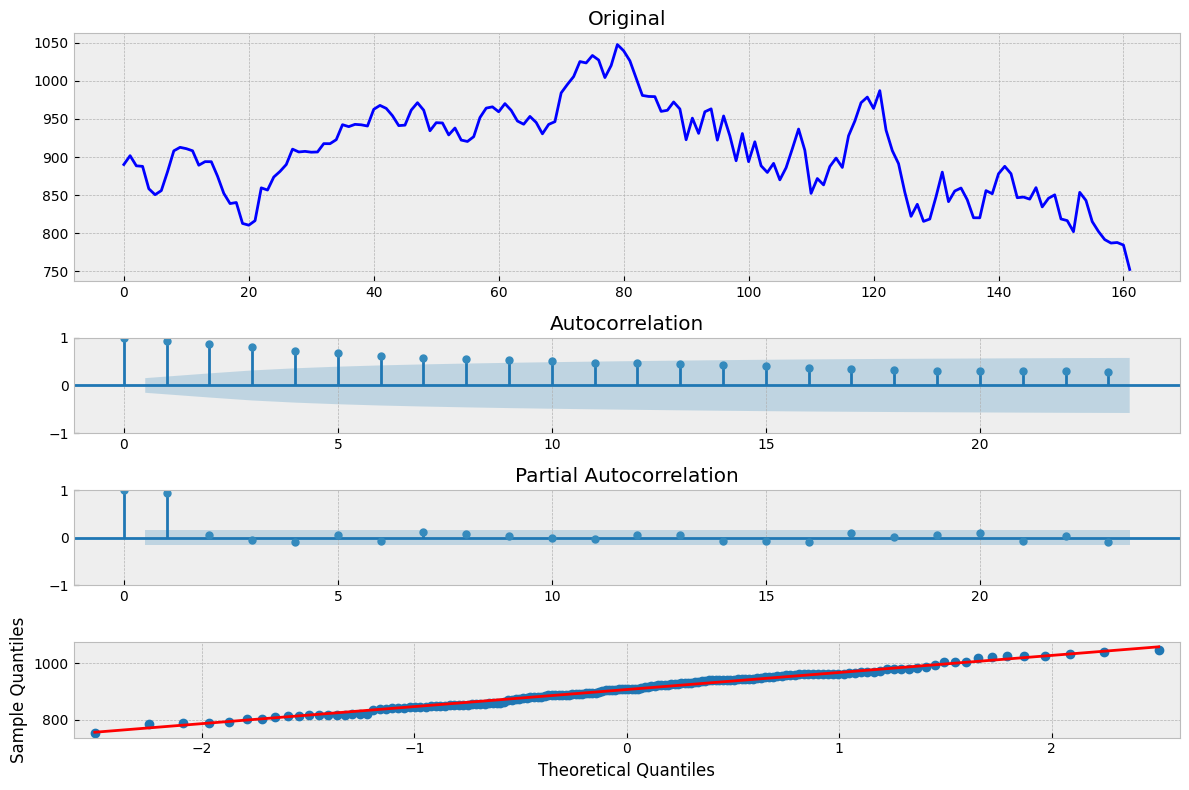

In [ ]:
tsplot(series)

Мы видим, что p-value больше установленного уровня значимости, а, следовательно, ряд нестационарен. Для GARCH необходимо сделать наш ряд стационарным. Однако сначала мы обучим ARIMA на нестационарных данных, чтобы получить оптимальные параметры.

In [ ]:
best_aic = np.inf
best_order = None
best_md_2 = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(series, order=(i,d,j)).fit()
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl_2 = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 1416.32751 | order: (2, 2, 3)


In [ ]:
mymodel_2 = smt.ARIMA(series, order =(2, 0, 3))
modelfit_2 = mymodel_2.fit()
print(modelfit_2.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  162
Model:                 ARIMA(2, 0, 3)   Log Likelihood                -711.411
Date:                Wed, 21 Jun 2023   AIC                           1436.821
Time:                        14:03:25   BIC                           1458.434
Sample:                             0   HQIC                          1445.597
                                - 162                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        890.9828     34.904     25.526      0.000     822.571     959.394
ar.L1          0.3069      0.276      1.113      0.266      -0.233       0.847
ar.L2          0.6084      0.274      2.218      0.0

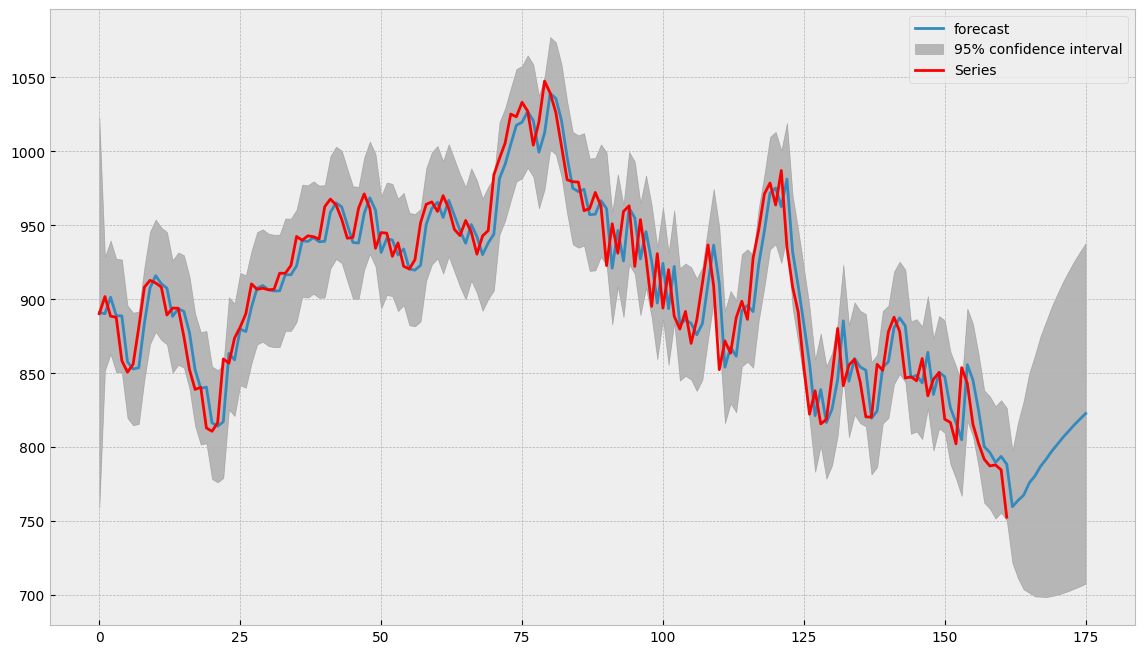

In [ ]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    plot_predict(modelfit_2, 0, 175, ax=ax)
    plt.plot(series, color='red', label='Series')
    plt.legend()
    plt.show()

Модель ARIMA подобрала оптимальные параметры 'p', 'o' и 'q' - 2, 2, 3. Теперь сделаем наш ряд стационарным и построим модель GARCH на полученных параметрах.

In [ ]:
dowjones_closings_diff = np.diff(series, 1)
dowjones_closings_diff = pd.Series(dowjones_closings_diff)
test_stationarity(dowjones_closings_diff)

Results of Dickey-Fuller Test:
Test Statistic                -1.302521e+01
p-value                        2.407586e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64


Ряд стал стационарным. Теперь можно строить GARCH-модель.

In [ ]:
pip install arch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 916.4/916.4 kB 14.7 MB/s eta 0:00:00


In [ ]:
from arch import arch_model

In [ ]:
p_ = 2
o_ = 2
q_ = 3

am = arch_model(dowjones_closings_diff, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -698.906
Distribution:      Standardized Student's t   AIC:                           1417.81
Method:                  Maximum Likelihood   BIC:                           1448.63
                                              No. Observations:                  161
Date:                      Wed, Jun 21 2023   Df Residuals:                      160
Time:                              14:03:34   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0

Коэффициенты $alpha$ измеряет степень влияния волатильности "сегодня" на волатильность следующего периода.

$beta$ - это параметр постоянства волатильности. Волатильность считается постоянной, если она оказывает влияние на безусловную дисперсию многих периодов в будущем. Т.е., сегодняшняя волатильность говорит нам что-то не только о волатильности завтра, но и о волатильности на много дней вперед.

Теперь что касается t-статистики. Обычная нулевая гипотеза - это то, что наш коэффициент не имеет никакого эффекта. Но мы можем отклонить её, если наше значение $p$ меньше $a$ (0,05)

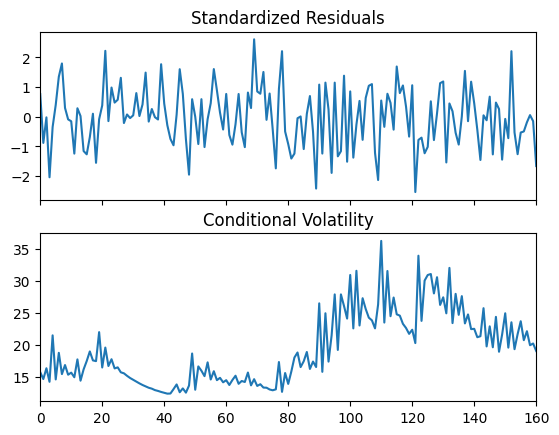

In [ ]:
res.plot()
plt.show()

Спрогнозируем условную дисперсию на 5 дней вперед.

In [ ]:
forecasts = res.forecast(horizon=5)
variance = forecasts.variance[-1:]
std_dev = np.sqrt(variance)
print(std_dev)

           h.1        h.2       h.3        h.4        h.5
160  25.029937  20.247631  23.24712  21.589722  22.399225
